In [ ]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = ""

# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [ ]:
print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

In [ ]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

In [33]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n - seq_length, batch_size)
    input_batch = [vectorized_songs[i : i + seq_length] for i in idx]
    output_batch = [vectorized_songs[i + 1 : i + seq_length + 1] for i in idx]

    # Convert the input and output batches to tensors
    x_batch = torch.tensor(input_batch, dtype=torch.long)
    y_batch = torch.tensor(output_batch, dtype=torch.long)

    return x_batch, y_batch

# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
x_batch, y_batch = get_batch(*test_args)
assert x_batch.shape == (2, 10), "x_batch shape is incorrect"
assert y_batch.shape == (2, 10), "y_batch shape is incorrect"
print("Batch function works correctly!")

Batch function works correctly!


In [34]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(x_batch[0], y_batch[0])):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx.item()])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx.item()])))

Step   0
  input: 60 (np.str_('e'))
  expected output: 62 (np.str_('g'))
Step   1
  input: 62 (np.str_('g'))
  expected output: 60 (np.str_('e'))
Step   2
  input: 60 (np.str_('e'))
  expected output: 1 (np.str_(' '))
Step   3
  input: 1 (np.str_(' '))
  expected output: 59 (np.str_('d'))
Step   4
  input: 59 (np.str_('d'))
  expected output: 27 (np.str_('B'))


In [35]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # Define each of the network layers
        # Layer 1: Embedding layer to transform indices into dense vectors
        #   of a fixed embedding size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        '''TODO: Layer 2: LSTM with hidden_size `hidden_size`. note: number of layers defaults to 1.
         Use the nn.LSTM() module from pytorch.'''
        self.lstm = nn.LSTM(embedding_dim, hidden_size) # TODO

        '''TODO: Layer 3: Linear (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size.'''
        self.fc = nn.Linear(hidden_size, vocab_size)  # TODO

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state with zeros
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))

    def forward(self, x, state=None, return_state=False):
        x = self.embedding(x)

        if state is None:
            state = self.init_hidden(x.size(1), x.device)
        out, state = self.lstm(x, state)

        out = self.fc(out)
        return out if not return_state else (out, state)

In [36]:
# Instantiate the model! Build a simple model with default hyperparameters. You
#     will get the chance to change these later.
vocab_size = len(vocab)
embedding_dim = 256
hidden_size = 1024
batch_size = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(vocab_size, embedding_dim, hidden_size).to(device)

# print out a summary of the model
print(model)

LSTMModel(
  (embedding): Embedding(83, 256)
  (lstm): LSTM(256, 1024)
  (fc): Linear(in_features=1024, out_features=83, bias=True)
)


In [37]:
# Test the model with some sample data
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
x = x.to(device)
y = y.to(device)

pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       torch.Size([32, 100])  # (batch_size, sequence_length)
Prediction shape:  torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)


In [38]:
sampled_indices = torch.multinomial(torch.softmax(pred[0], dim=-1), num_samples=1)
sampled_indices = sampled_indices.squeeze(-1).cpu().numpy()
sampled_indices

array([20, 74, 39, 37, 52, 66, 69, 48, 79, 66, 45,  1, 66, 14, 48, 31, 24,
       46, 60,  4, 11, 62, 16, 57, 75, 74,  9, 67, 66, 46, 70, 44, 36,  4,
        3, 51, 28, 59, 18,  7,  7, 26, 48, 25,  3, 62, 73, 47, 44, 69, 76,
       19, 11, 36, 60, 70, 29,  5, 45, 47, 28, 13, 39,  3, 13, 12, 57,  6,
       59, 66, 41, 52, 11, 72, 16, 36, 63, 65, 58, 22, 64, 64, 24, 42, 30,
       30, 62, 32, 32, 33, 48, 73, 46, 72, 75, 24, 31, 18, 37, 25])

In [39]:
print("Input: \n", repr("".join(idx2char[x[0].cpu()])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 "\nT:Martin Wynne's No. 1\nZ: id:dc-reel-196\nM:C\nL:1/8\nK:D Major\nB|AFF2 GEE2|DFF2 EFDB|ABDE F3B|ABde fe"

Next Char Predictions: 
 '8sNL[knWxkT k2WF=Ue#/g4bts-lkUoSK#"ZCd6))AW>"grVSnu7/KeoD\'TVC1N"10b(dkP[/q4Khjc:ii=QEEgGGHWrUqt=F6L>'


In [40]:
cross_entropy = nn.CrossEntropyLoss() # instantiates the function
def compute_loss(labels, logits):
    """
    Inputs:
      labels: (batch_size, sequence_length)
      logits: (batch_size, sequence_length, vocab_size)

    Output:
      loss: scalar cross entropy loss over the batch and sequence length
    """

    # Batch the labels so that the shape of the labels should be (B * L,)
    batched_labels = labels.view(-1)

    ''' TODO: Batch the logits so that the shape of the logits should be (B * L, V) '''
    batched_logits = logits.view(-1, logits.shape[-1])  # TODO

    '''TODO: Compute the cross-entropy loss using the batched  next characters and predictions'''
    loss = cross_entropy(batched_logits, batched_labels) # TODO
    return loss

In [41]:
y.shape  # (batch_size, sequence_length)
pred.shape  # (batch_size, sequence_length, vocab_size)

'''TODO: compute the loss using the true next characters from the example batch
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) # TODO

print(f"Prediction shape: {pred.shape} # (batch_size, sequence_length, vocab_size)")
print(f"scalar_loss:      {example_batch_loss.item()}")

Prediction shape: torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)
scalar_loss:      4.428513050079346


In [42]:
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

# Model parameters:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  hidden_size = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
os.makedirs(checkpoint_dir, exist_ok=True)

In [43]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

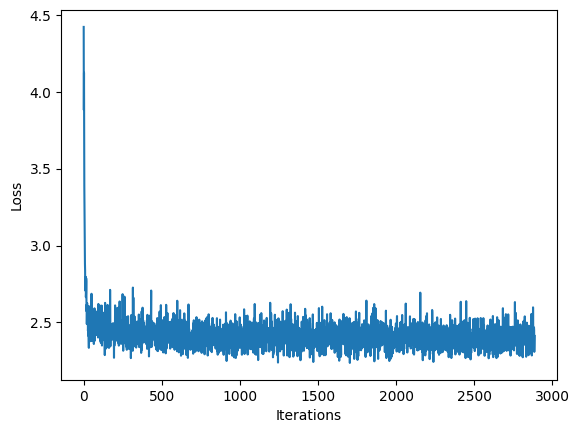

100%|██████████| 3000/3000 [00:38<00:00, 77.91it/s]
COMET INFO: Uploading 248 metrics, params and output messages


True

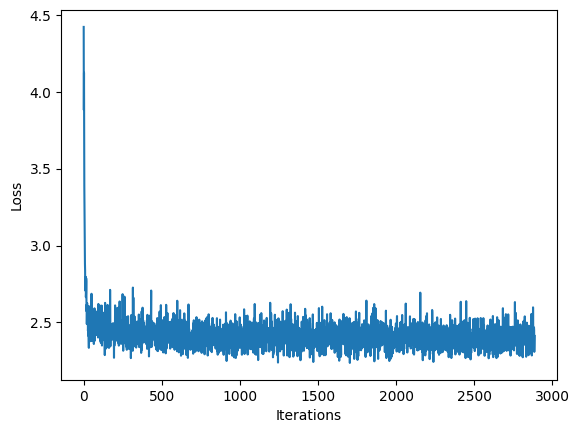

In [44]:
'''TODO: instantiate a new LSTMModel model for training using the hyperparameters
    created above.'''
model = LSTMModel(vocab_size, params['embedding_dim'], params['hidden_size'])  # TODO: arguments

# Move the model to the GPU
model.to(device)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the PyTorch website for a list of supported optimizers.
  https://pytorch.org/docs/stable/optim.html
  Try using the Adam optimizer to start.'''
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])  # TODO

def train_step(x, y):
    # Set the model's mode to train
    model.train()

    # Zero gradients for every step
    optimizer.zero_grad()

    # Forward pass
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)  # TODO

    # Compute the loss
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)  # TODO

    # Backward pass
    '''TODO: complete the gradient computation and update step.
    Remember that in PyTorch there are two steps to the training loop:
    1. Backpropagate the loss
    2. Update the model parameters using the optimizer
    '''
    loss.backward()  # TODO
    optimizer.step()  # TODO

    return loss

# ... (rest of the code remains the same)
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])

    # Convert numpy arrays to PyTorch tensors
    x_batch = torch.tensor(x_batch, dtype=torch.long).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)

    # Take a train step
    loss = train_step(x_batch, y_batch)

    # Log the loss to the Comet interface
    experiment.log_metric("loss", loss.item(), step=iter)

    # Update the progress bar and visualize within notebook
    history.append(loss.item())
    plotter.plot(history)

    # Save model checkpoint
    if iter % 100 == 0:
        torch.save(model.state_dict(), checkpoint_prefix)

# Save the final trained model
torch.save(model.state_dict(), checkpoint_prefix)
experiment.flush()

In [46]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_idx = [char2idx[s] for s in start_string]  # TODO
  input_idx = torch.tensor([input_idx], dtype=torch.long).to(device)

  # Initialize the hidden state
  state = model.init_hidden(input_idx.size(0), device)

  # Empty string to store our results
  text_generated = []
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
    '''TODO: evaluate the inputs and generate the next character predictions'''
    predictions, state = model(input_idx, state, return_state=True)  # TODO

    # Remove the batch dimension
    predictions = predictions.squeeze(0)

    '''TODO: use a multinomial distribution to sample over the probabilities'''
    predicted_idx = torch.multinomial(torch.softmax(predictions[-1], dim=-1), num_samples=1).item()  # TODO

    '''TODO: add the predicted character to the generated text!'''
    # Hint: consider what format the prediction is in vs. the output
    text_generated.append(idx2char[predicted_idx])  # TODO

    # Pass the prediction to the model
    input_idx = torch.tensor([[predicted_idx]], dtype=torch.long).to(device)

  return (start_string + ''.join(text_generated))

In [47]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, "X", generation_length=1000) # TODO

100%|██████████| 1000/1000 [00:00<00:00, 1171.61it/s]


In [48]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

Found 5 songs in text


In [49]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : favourite_dormouse_3043
COMET INFO:     url                   : https://www.comet.com/code2aum/6s191-lab1-part2/fc74687e940c4319a149eefd22b3d5dc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3300] : (2.2351768016815186, 4.424993991851807)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1OkCR0_nc8dD3vUSEOOnIfsHaILDhnA0y
COMET INFO:   Parameters:
COMET INFO:     batch_size              : 8
COMET INFO:     embedding_dim           : 256
COMET INFO:     hidden_size             : 1024
COMET INFO:     learning_rate           : 0.005
COMET INFO:     num_training_iterations : 3000
COMET 